# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from functions.epsilon_greedy_agent import get_action_epsilon_greedy
from functions.rewards import get_reward
from tqdm import tqdm
from functions.ucb_agent import train_ucb_agent_non_stat
from functions.epsilon_greedy_agent import train_agent_epsilon_greedy_non_stat

C:\Users\lucas\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Simulation parameters

In [5]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Maximal time in s
C_T_MAX = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = -1
# Sampling frequency in Hz
C_SAMPLING_FREQ_HZ = 1
# Coherence time in s
C_COHERENCE_S = 60
# Power spread in dB
C_POWER_SPREAD = 10
# Bitrates in bits/s
# For each modulation, two new modulations 
# schemes are redefined with power +/- 3 dB
# and same bitrate
C_BITRATES_BITS_PER_S = np.array([2520, 2520, 2520, 840, 840, 840, 360, 360, 360, 168, 168, 168])
# Relative power 
C_POWERS = np.array([0.5, 1, 2, 0.5, 1, 2, 0.5, 1, 2, 0.5, 1, 2])

# Non-stationary SNR and PER

In [6]:
def ar1_channel_power(P_avg_dB, sigma2_P_dB, tc, fs, D):
    n_tc = tc*fs
    phi = np.exp(-np.log(2)/n_tc)
    var_e = sigma2_P_dB*(1 - phi**2)
    
    C_NWARM = 50
    N = np.ceil(D*fs).astype(int)

    Y = np.zeros(C_NWARM + N)
    e = np.sqrt(var_e)*np.random.randn(C_NWARM + N)

    for k in range(1, C_NWARM + N):
        Y[k] = phi*Y[k-1] + e[k]

    P_dB = P_avg_dB + Y[C_NWARM:]

    return P_dB

In [7]:
# Get the SNR trajectory
v_snr = ar1_channel_power(C_SNR_DB, C_POWER_SPREAD, C_COHERENCE_S, C_SAMPLING_FREQ_HZ, C_T_MAX)

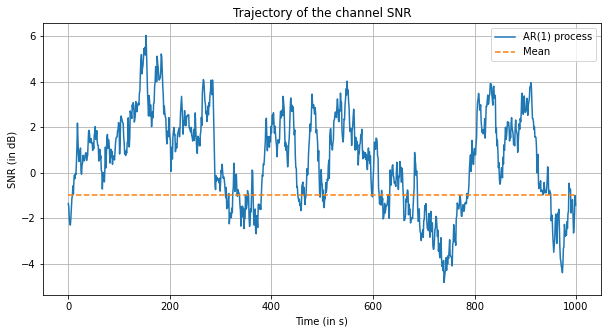

In [8]:
# Plot of the SNR trajectory
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(v_snr, label = "AR(1) process")
ax.plot(np.ones_like(v_snr) * C_SNR_DB, label = "Mean", linestyle = "dashed")
ax.set_xlabel('Time (in s)')
ax.set_ylabel('SNR (in dB)')
ax.set_title('Trajectory of the channel SNR')
ax.grid(True)
ax.legend()
plt.show()

# Interpolation of the PER curves on the SNR trajectory

In [9]:
def supposed(x , alpha, offset, factor, up):
    return factor*(((np.exp(-alpha*(x-offset)) - np.exp(alpha*(x-offset)))/(np.exp(-alpha*(x-offset)) + np.exp(alpha*(x-offset)))) + up)

def anal_estimation(supposed_general_form, x_data, y_data):
    popt, _ = curve_fit(supposed_general_form, x_data, y_data,bounds=([0,-20,0,0],[2,20,1,5]), maxfev=5000)
    alpha, offset, factor, up = popt
    
    def estimation(X):
        return supposed(X, alpha, offset, factor, up)
    
    return estimation

In [10]:
# Read the .csv file containing the PER
df = pd.read_csv('data/TEP_vs_SNR.csv')
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]

df_per = pd.DataFrame()
df_per['SNR'] = df.T.index[1:].astype(np.float32)
df_per['TEP_DSSS1'] = df.T[0].to_list()[1:]
df_per['TEP_DSSS3'] = df.T[1].to_list()[1:]
df_per['TEP_DSSS7'] = df.T[2].to_list()[1:]
df_per['TEP_DSSS15'] = df.T[3].to_list()[1:]


# Interpolation
f_DSSS1 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS1']))
f_DSSS3 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS3']))
f_DSSS7 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS7']))
f_DSSS15 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS15']))

# Compute the PER values for each modulation at each time
# using the interpolations
per_values = np.vstack((f_DSSS1(v_snr - 3), f_DSSS1(v_snr), f_DSSS1(v_snr + 3), f_DSSS3(v_snr - 3), f_DSSS3(v_snr), f_DSSS3(v_snr + 3), f_DSSS7(v_snr - 3), f_DSSS7(v_snr), f_DSSS7(v_snr + 3), f_DSSS15(v_snr - 3), f_DSSS15(v_snr), f_DSSS15(v_snr + 3))).T

# Correct interpolation errors: probabilty greater than one or less than 0
per_values = np.minimum(per_values, 1)
per_values = np.maximum(per_values, 0)

Text(0.5, 0.98, 'Packet Error Rates trajectories')

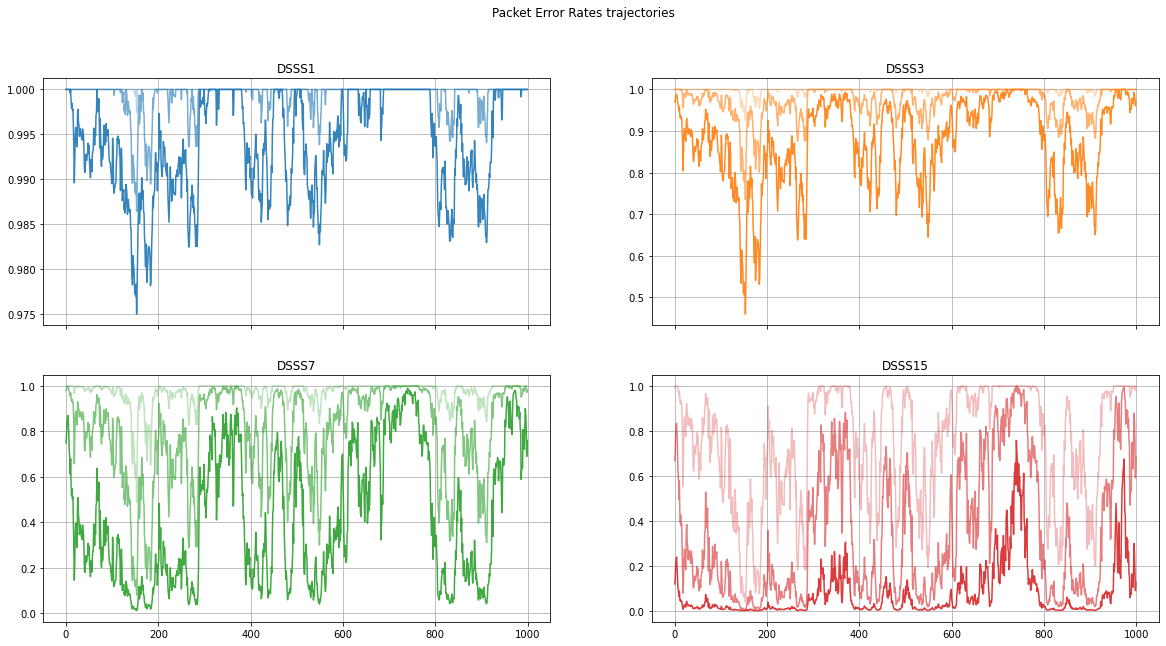

In [11]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]
# Plot of the inteprolated PER curves
fig, axs = plt.subplots(2,2, figsize=(20, 10), sharex=True)
axs = axs.ravel()
i = 0
for (n_ax, ax) in enumerate(axs) :
    ax.plot(per_values[:, i], label = labels[n_ax] + " - 3 dB", color = colors[n_ax], alpha = 0.3)
    ax.plot(per_values[:, i + 1], label = labels[n_ax], color = colors[n_ax], alpha = 0.6)
    ax.plot(per_values[:, i + 2], label = labels[n_ax] + " + 3 dB", color = colors[n_ax], alpha = 0.9)
    ax.grid(True)
    ax.set_title(labels[n_ax])
    i += 3

# fig.supxlabel('Time (in s)')
# fig.supylabel('Packet Error Rate')
fig.suptitle('Packet Error Rates trajectories')

Text(0.5, 0.98, 'Expected Rewards')

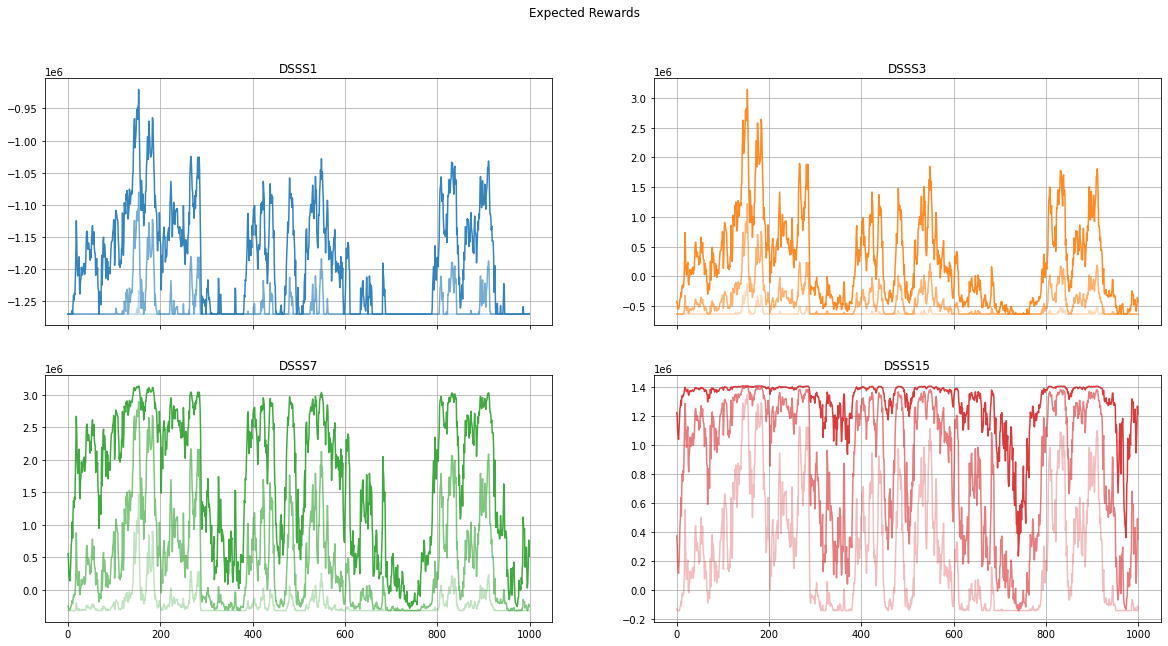

In [12]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]
rewards = C_BITRATES_BITS_PER_S**2 / C_POWERS
# Plot of the inteprolated PER curves
fig, axs = plt.subplots(2,2, figsize=(20, 10), sharex=True)
axs = axs.ravel()
i = 0
for (n_ax, ax) in enumerate(axs) :
    ax.plot(rewards[n_ax] * (1-per_values[:, i]) - 0.1*rewards[n_ax] * per_values[:, i], label = labels[n_ax] + " 3 dB", color = colors[n_ax], alpha = 0.3)
    ax.plot(rewards[n_ax] * (1-per_values[:, i + 1])- 0.1*rewards[n_ax] * per_values[:, i+1], label = labels[n_ax], color = colors[n_ax], alpha = 0.6)
    ax.plot(rewards[n_ax] * (1-per_values[:, i + 2])- 0.1*rewards[n_ax] * per_values[:, i+2], label = labels[n_ax] + " 3 dB", color = colors[n_ax], alpha = 0.9)
    ax.grid(True)
    ax.set_title(labels[n_ax])
    i += 3
# fig.supxlabel('Time (in s)')
# fig.supylabel('Expected Reward (in bits/s/J)')
fig.suptitle('Expected Rewards')

# Experiments using an $\epsilon$-greedy agent

In [13]:
eps=0.1

In [14]:
rewards, action_values, action_counts = train_agent_epsilon_greedy_non_stat(per_values=per_values, bitrates=C_BITRATES_BITS_PER_S**2 / C_POWERS, n_agents=C_N_AGENTS, n_iter = int(C_T_MAX * C_SAMPLING_FREQ_HZ), eps = eps, alpha = .1)

No handles with labels found to put in legend.


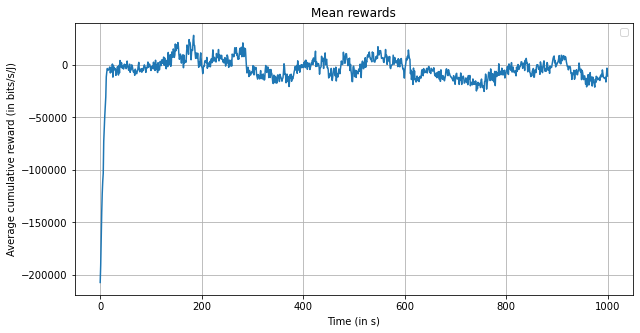

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(rewards, axis=1)[0:], color='tab:blue')
ax.grid(True)
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Average cumulative reward (in bits/s/J)')
ax.set_title(r'Mean rewards')
ax.legend()
plt.show()

Text(0, 0.5, 'Ratios')

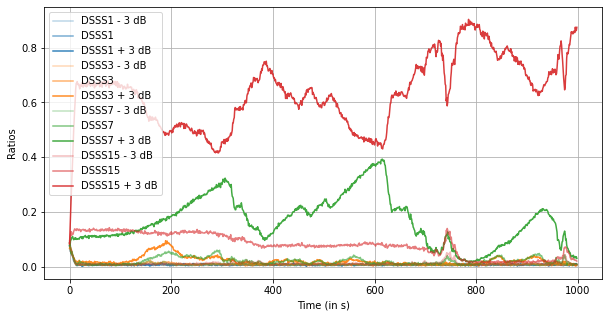

In [16]:
# Get the ratios
action_ratios = np.mean(action_counts[1:, :, :] - action_counts[:-1, :, :], axis = 1)

# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
i = 0
for n in range(4):
        ax.plot(action_ratios[:, i], label = labels[n] + " - 3 dB", color = colors[n], alpha = 0.3)
        ax.plot(action_ratios[:, i + 1], label = labels[n], color = colors[n], alpha = 0.6)
        ax.plot(action_ratios[:, i + 2], label = labels[n] + " + 3 dB", color = colors[n], alpha = 0.9)
        i += 3
ax.grid()
ax.legend(loc = "best")
ax.set_xlabel("Time (in s)")
ax.set_ylabel("Ratios")

## Estimated action-values

Text(0.5, 0.98, 'Expected Rewards')

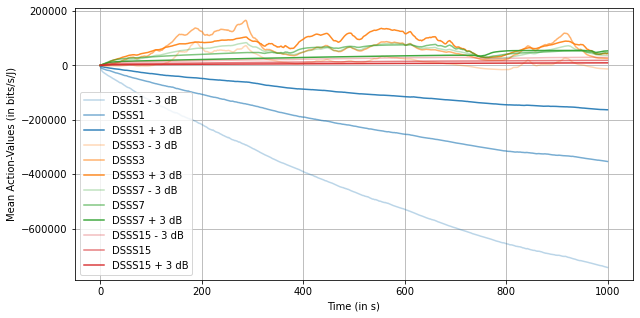

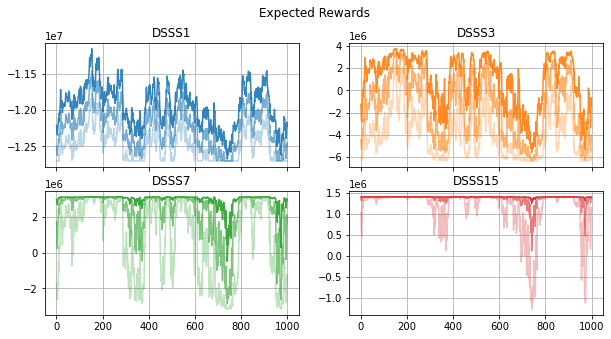

In [24]:
# Compute the mean action values estimates
mean_action_values = np.mean(action_values, axis = 1)

# Plot of the action values estimates
fig, ax = plt.subplots(figsize=(10, 5))
i = 0
for n in range(4):
        ax.plot(mean_action_values[:, i], label = labels[n] + " - 3 dB", color = colors[n], alpha = 0.3)
        ax.plot(mean_action_values[:, i + 1], label = labels[n], color = colors[n], alpha = 0.6)
        ax.plot(mean_action_values[:, i + 2], label = labels[n] + " + 3 dB", color = colors[n], alpha = 0.9)
        i += 3
ax.grid()
ax.legend(loc = "best")
ax.set_xlabel("Time (in s)")
ax.set_ylabel("Mean Action-Values (in bits/s/J)")


# esperance evolution over time for each modulation
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]
rewards = C_BITRATES_BITS_PER_S**2 / C_POWERS
# Plot of the inteprolated PER curves
fig, axs = plt.subplots(2,2, figsize=(10, 5), sharex=True)
axs = axs.ravel()
i = 0
for (n_ax, ax) in enumerate(axs) :
    ax.plot(rewards[n_ax] * (1-per_values[:, i]) - rewards[n_ax] * per_values[:, i], label = labels[n_ax] + " 3 dB", color = colors[n_ax], alpha = 0.3)
    ax.plot(rewards[n_ax] * (1-per_values[:, i + 1])- rewards[n_ax] * per_values[:, i+1], label = labels[n_ax], color = colors[n_ax], alpha = 0.6)
    ax.plot(rewards[n_ax] * (1-per_values[:, i + 2])- rewards[n_ax] * per_values[:, i+2], label = labels[n_ax] + " 3 dB", color = colors[n_ax], alpha = 0.9)
    ax.grid(True)
    ax.set_title(labels[n_ax])
    i += 3
# fig.supxlabel('Time (in s)')
# fig.supylabel('Expected Reward (in bits/s/J)')
fig.suptitle('Expected Rewards')



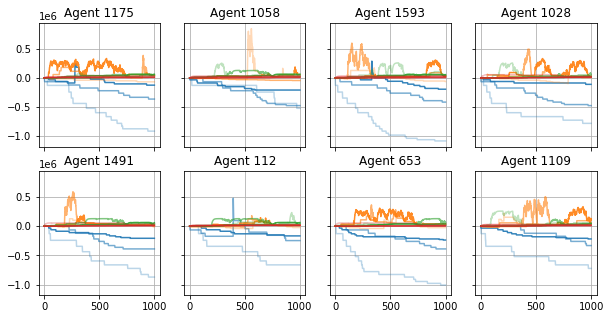

In [25]:
# Plot of multiple agents action-values
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
axs = axs.ravel()

for ax in axs :
    
    n_agent = np.random.randint(2000)
    i = 0
    for n in range(4):
        ax.plot(action_values[:, n_agent, i], label = labels[n] + " - 3 dB", color = colors[n], alpha = 0.3)
        ax.plot(action_values[:, n_agent, i + 1], label = labels[n], color = colors[n], alpha = 0.6)
        ax.plot(action_values[:, n_agent, i + 2], label = labels[n] + " + 3 dB", color = colors[n], alpha = 0.9)
        i += 3
    ax.set_title(f"Agent {n_agent + 1}")
    ax.grid()


# fig.supxlabel("Time (in s)")
# fig.supylabel("Agent's Action-Values")